# 07 - 控制混淆因素之外的考虑


## 良好的控制

我们已经看到向我们的回归模型添加额外的控制可以帮助识别因果效应。如果控制是一个混杂因素，将它添加到模型中不仅很好，而且是一项要求。当粗心大意的人看到这一点时，自然的反应是将他能测量的任何东西都扔进模型中。在当今的大数据世界中，这很容易超过 1000 个变量。事实证明，这不仅是不必要的，而且可能不利于因果识别。我们现在将注意力转向非混杂因素的控制。首先，让我们来看看好的。然后，我们将深入研究有害控制。

作为一个激励示例，假设您是一家金融科技公司收集团队的数据科学家。您的下一个任务是弄清楚发送电子邮件要求人们协商债务的影响。您的响应变量是迟到客户的付款金额。

为了回答这个问题，您的团队从您的迟到客户群中随机选择了 5000 名客户进行随机测试。对于每个客户，您抛硬币，如果是正面，客户就会收到电子邮件；否则，它作为一个控制。通过此测试，您希望了解电子邮件产生的额外收入。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


由于数据是随机的，您知道均值的简单差异估计平均治疗效果。换句话说，除了随机化之外，没有什么可以引起治疗，因此潜在的结果与治疗无关：\\((Y_0，Y_1 ) \perp T \\)。

$
ATE = E[Y_i|T_i=1] - E[Y_i|T_i=0]
$

由于您很聪明，并且希望在估计值周围放置置信区间，因此使用线性回归。

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


可悲的是，估计的ATE为-0.62，这很奇怪。发送电子邮件如何使迟到的客户支付的费用低于平均水平？尽管如此，P值仍然如此之高，以至于这可能没有任何意义。你现在应该做什么？回到你的团队，把尾巴夹在两腿之间，说测试没有定论，你需要更多的数据？没那么快。

请注意您的数据如何包含其他一些有趣的列。例如，"credit_limit"表示客户在迟到之前的信用额度。"risk_score"对应于客户在发送电子邮件之前的估计风险。认为信用额度和风险可能是很好的付款预测因素是有道理的。但这有什么用呢？

首先，让我们了解为什么即使存在，我们也无法在治疗中找到统计显著性。可能是，就像在这种情况下一样，治疗对结果的影响很小。如果你仔细想想，让人们偿还债务的原因，总的来说，是收款部门无法控制的因素。人们偿还债务是因为他们找到了一份新工作，管理他们的财务，收入等等。在统计方面，我们可以说**付款的可变性更多地由电子邮件**以外的其他因素解释。

为了直观地理解它，我们可以根据治疗变量电子邮件绘制付款。我还用红色绘制了上面模型的拟合线。为了帮助可视化，我在电子邮件变量中添加了一点噪音，这样它就不会在零或一处被粉碎。

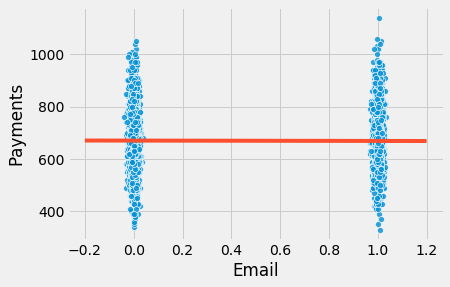

In [4]:
sns.scatterplot("email", "payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

我们可以看到单个治疗组中的付款差异有多大。从视觉上看，看起来两组都从400以下到1000。如果电子邮件的影响是5.00或10.00 R $，难怪很难在所有可变性中找到它。


幸运的是，回归可以帮助我们降低这种可变性。诀窍是使用其他控件。**如果变量是结果的良好预测因子，它将解释其许多差异**。如果风险和信用额度是付款的良好预测因素，我们可以控制它们，以便更容易地发现电子邮件对付款的影响。如果我们记得回归是如何工作的，这有一个直观的解释。向回归添加额外的变量意味着在查看治疗时保持它们不变。因此，推理是，如果我们看一下类似的风险水平和信用额度，响应变量"付款"的方差应该更小。或者，换句话说，如果风险和信用额度可以很好地预测付款，则具有相似风险和信用额度的客户也应该具有相似的付款水平，因此差异较小。

![img](./data/img/beyond-conf/y-pred.png)


为了证明这一点，让我们采用将回归分为2个步骤的偏出方式。首先，我们将在额外的控制，信用额度和风险评分上回归治疗，电子邮件，结果，付款。其次，我们将在步骤1中获得的付款剩余量上回归处理的剩余值。（这纯粹是教学法，在实践中你不需要经历所有的麻烦）。

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

这将降低因变量的方差。通过对信用额度和风险的回归支付并获得此模型的残差，我们正在创建一个新的因变量，其可变性比原始变量小得多。最后一个模型还发现了具有有效标准误差估计值的 ATE。

只是出于好奇，我们还可以检查预测治疗的模型不应该能够降低它的方差。这是因为电子邮件在设计上是随机的，所以没有什么可以预测它。

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.61241599994
Payments Residual Variance 5652.453558466197
Email Variance 0.24991536000001294
Email Residual Variance 0.24918421069820038


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.143e-13,1.063,3.9e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


请注意付款的差异如何从 10807 变为 5652。一旦我们控制了风险和信用额度，我们已经将其降低了近一半。另请注意，我们没有设法减少治疗电子邮件的可变性。这是有道理的，因为风险和信用额度不能预测电子邮件（根据随机性的定义，什么都不可以预测）。

现在，我们看到一些更合理的东西。这一新的估计告诉我们，我们应该期望收到电子邮件的客户平均比对照组多支付4.4雷亚尔。现在，此估计值在统计上与零不同。我们还可以想象每个对照组中的方差现在如何降低。

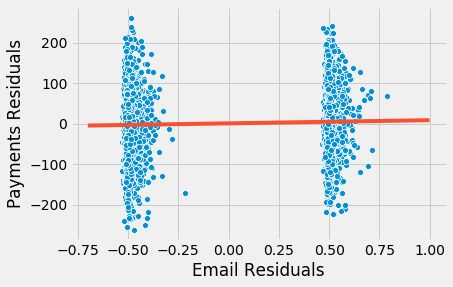

In [7]:
sns.scatterplot("res_email", "res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

正如我所说，我们这样做是出于教学原因。在实践中，您只需将控件与处理一起添加到回归模型中，估计值将完全相同。

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


总而言之，每当我们有一个控件可以很好地预测结果时，即使它不是混杂因素，将其添加到我们的模型中也是一个好主意。它有助于降低我们治疗效果估计的方差。这是一张因果图的情况图片。

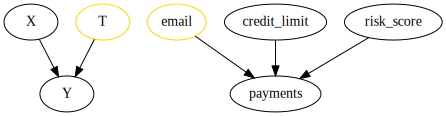

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## 主要是有害的对照

作为第二个启发用的示例，让我们考虑一个2家医院都在进行的药物测试场景。他们都在对一种治疗某种疾病的新药进行随机试验。感兴趣的结果是住院天数。如果治疗有效，它将减少患者在医院停留的天数。对于其中一家医院，有关随机治疗的策略是将其给予90%的患者，而10%的患者接受安慰剂。另一家医院有不同的策略：它随机给10%的患者提供药物，90%的患者服用安慰剂。您还被告知，提供90%的真正药物和10%安慰剂的医院通常会得到更严重的疾病病例进行治疗。

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


由于您正在处理随机数据，因此您的第一本能是简单地对治疗结果进行回归。

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


但是你会发现一些违反直觉的结果。治疗如何增加住院天数？答案在于我们正在运行2个不同的实验。严重程度与在医院的天数较多呈正相关，并且由于病例较重的医院也给予更多的药物，因此药物与在医院的天数呈正相关。当我们一起看两家医院时，我们有 \\(E[Y_0|T=0]>E[Y_0|T=1]\\) ，也就是说，平均而言，未治疗者的潜在结果高于接受治疗者，因为在病情较轻的医院中，未治疗的病例较多。换句话说，严重程度起到了混杂因素的作用，决定了患者去的医院，从而决定了接受药物的可能性。

有两种方法可以解决这个问题。第一个破坏了使用两家医院数据的目的，即简单地单独查看每家医院的ATE。

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


在本例中，我们确实得到了 ATE 的直观结果。看起来现在这种药物实际上正在降低在医院的天数。但是，由于我们单独查看每家医院，因此没有足够的数据点。因此，我们无法找到具有统计学意义的结果。

另一种利用回归功能的方法是通过将其包含在模型中来控制严重性。

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


接下来出现的问题是，我们是否也应该将医院纳入模型？毕竟，我们知道医院造成的治疗对吗？嗯，这是真的，但是一旦我们控制了严重程度，医院就不再与住院天数的结果相关。我们知道，要成为混杂因素，变量必须同时引起治疗和结果。在这种情况下，我们有一个仅导致治疗的变量。

但也许控制它会降低方差，对吧？好吧，又不是真的。为了使对照降低方差，它必须是结果的良好预测因子，而不是治疗的预测因子，这里的情况就是如此。

不过，我们可能想控制它吗？它不会伤害...还是可以？

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


令人惊讶的是，它会带来不对的结果！

![img](./data/img/beyond-conf/shocked.png)

在严重性之上添加医院作为对照，为我们的 ATE 估计器引入了更多差异。怎么可能？答案在于回归系数标准误的公式。

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

从这个公式可以看出，标准误差与变量\\(X\\)的方差成反比。这意味着，如果 \\(X\\) 变化不大，则很难估计其对结果的影响。这也具有直观意义。把它发挥到极致，假装你想估计一种药物的效果，所以你对 10000 人进行了测试，但只有 1 人得到了治疗。这将使找到 ATE 变得非常困难，我们将不得不依靠将一个人与其他人进行比较。另一种说法是，我们需要在治疗中进行很多可变性，以便更容易发现其影响。

至于为什么在模型中包括医院会增加我们估计的误差，这是因为它是治疗而不是结果的良好预测指标（一旦我们控制了严重程度）。所以，通过预测治疗，它有效地使它的方差更低！再一次，我们可以将上面的回归划分为 2 个步骤来查看这一点。

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.498e-14,0.827,3.02e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.057529091872119076


还有，不要只相信我的话！ 您可以检查上面的 SE 公式是否正确：

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.4469737674869028


所以最重要的是，我们应该添加与治疗和结果（混杂因素）相关的控制，如上面模型中的严重程度。 我们还应该添加可以很好地预测结果的控制，即使它们不是混杂因素，因为它们降低了我们估计的方差。 但是，我们应该**不**添加只是治疗的良好预测因子的对照，因为它们会增加我们估计的方差。

这是一张用因果图说明这种情况的图片。

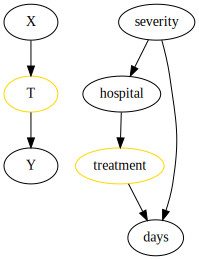

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## 不良控制 - 选择偏差

让我们回到集合电子邮件示例。 请记住，电子邮件是随机分配给客户的。 我们已经解释了什么是“credit_limit”和“risk_score”。 现在，让我们看看剩下的变量。 `opened` 是客户是否打开电子邮件的虚拟变量。 如果客户在收到电子邮件后联系收款部门协商他们的债务，“协议”是另一个虚拟标记。 您认为以下哪个模型更合适？ 第一个是带有处理变量加上 `credit_limit` 和 `risk_score` 的模型； 第二个添加了 `opened` 和 `agreement` 假人。

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


虽然第一个模型发现电子邮件的统计显着结果，但第二个模型没有。但也许第二个是正确的模型并且对电子邮件没有影响。毕竟，这个模型控制的因素更多，所以它应该更健壮吧？现在您可能知道情况并非如此。剩下的就是弄清楚是什么。

我们知道我们必须添加混淆变量。导致治疗和结果的变量。我们也知道添加能够很好地预测结果的控制是一个好主意。这不是必需的，但很高兴拥有。我们也知道添加仅预测治疗的对照是一个坏主意。同样，这不是致命的罪过，但最好避免。那么`open`和`agreement`是怎样的控件呢？事实证明，它们都不是上述情况。

如果你仔细想想，‘opened’和‘agreement’肯定与电子邮件相关。毕竟，如果您没有收到电子邮件，您将无法打开它，而且我们还说过，该协议仅考虑在电子邮件发送后发生的重新谈判。但是**他们不会产生电子邮件！相反，它们是由它引起的！**

每当我需要了解我正在处理的变量类型时，我总是喜欢考虑它们的因果图。让我们在这里做这些

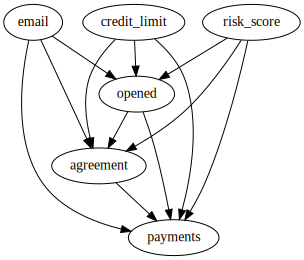

In [22]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

我们知道没有什么会导致电子邮件，因为它是随机设计的。我们知道（或者至少我们有充分的理由相信）信用额度和风险会导致付款。我们还认为电子邮件会导致付款。至于‘opened’，我们认为它确实引起了付款。直觉上，打开催收电子邮件的人更愿意谈判和偿还债务。我们还认为，“opened”会导致达成协议，其原因与导致付款的原因相同。此外，我们知道“opened”是由电子邮件引起的，我们有理由相信不同风险和信用额度的人对电子邮件的打开率不同，因此信用额度和风险也会导致打开。至于协议，我们也认为是`open`造成的。如果我们考虑支付响应变量，我们可以认为是漏斗的结果：

$
电子邮件 -> 打开 -> 协议 -> 付款
$

我们也认为不同程度的风险和线路有不同的达成一致的倾向，所以我们将它们标记为也引起一致。至于电子邮件和协议，我们可以说有些人只是阅读了电子邮件的主题，这使他们更有可能达成协议。关键是电子邮件也可以在不通过 open 的情况下达成一致。

我们在这张图中注意到，打开和协议都在从电子邮件到付款的因果路径中。所以，如果我们用回归来控制它们，我们会说“这是电子邮件的效果，同时保持‘打开’和‘协议’固定”。然而，两者都是电子邮件因果效应的一部分，所以我们不想固定它们。相反，我们可以争辩说电子邮件增加付款正是因为它提高了协议率。如果我们修复了这些变量，我们就会从电子邮件变量中消除一些真正的影响。

有了潜在的结果符号，我们可以说，由于随机化\\(E[Y_0|T=0] = E[Y_0|T=1]\\)。然而，即使是随机化，当我们控制一致性时，治疗和控制也不再具有可比性。事实上，通过一些直观的思考，我们甚至可以猜测它们的不同之处：


$
E[Y_0|T=0，协议=0] > E[Y_0|T=1，协议=0]
$

$
E[Y_0|T=0, 协议=1] > E[Y_0|T=1, 协议=1]
$

第一个等式明确表明，我们认为没有电子邮件和协议的人比有电子邮件和没有协议的人更好。那是因为，如果治疗有积极的效果，那些没有达成协议**即使在收到电子邮件之后**可能比那些也没有达成协议但也没有达成协议的人在付款方面更糟糕没有得到电子邮件的额外奖励。至于第二个等式，那些即使没有接受治疗也同意的人可能比那些同意但有电子邮件额外激励的人要好。

当您第一次阅读它时（这是给我的），这可能会非常令人困惑，但请确保您理解它。如有必要，请再次阅读。然后，可以对打开的变量进行类似的推理。尝试自己制作。

这种偏见是如此普遍，它有自己的名字。混杂是由于无法控制一个共同原因而产生的偏差，**选择偏差是指我们控制一个共同的结果或从原因到结果的路径之间的变量。** 根据经验，始终包括混杂因素和可以很好地预测模型中 \\(Y\\) 的变量。始终排除仅 \\(T\\)、治疗和结果之间的中介或治疗和结果的共同影响的良好预测变量的变量。

![img](./data/img/beyond-conf/selection.png)

选择偏差是如此普遍，以至于即使是随机化也无法解决它。更好的是，它经常被不明智的人引入，即使是在随机数据中！发现和避免选择偏差需要更多的练习而不是技巧。通常，它们出现在一些所谓的聪明想法之下，使其更难被发现。以下是我遇到的一些选择偏向的例子：

    1. 在尝试估计收款策略对付款的影响时，添加用于支付全部债务的虚拟变量。
    2. 在尝试估计教育对收入的影响时控制白领和蓝领工作
    3. 估计利率对贷款久期影响时的转换控制
    4. 在估计孩子对婚外情的影响时控制婚姻幸福
    5. 将支付建模 E[Payments] 分解为一个预测是否会发生支付的二元模型和另一个预测会发生多少支付的模型：E[Payments|Payments>0]*P(Payments>0)
    
所有这些想法值得注意的是它们听起来多么合理。 选择偏差常常如此。 让这成为一个警告。 事实上，我自己也曾多次掉入上面的陷阱，我才知道它们有多糟糕。 特别是最后一个，值得进一步解释，因为它看起来很聪明，让很多数据科学家措手不及。 它是如此普遍以至于它有自己的名字：**The Bad COP**！

### 糟糕的 COP

情况是这样的。 您有一个想要预测的连续变量，但其分布在零时被过度表示。 例如，如果您想对消费者支出进行建模，您将得到类似伽马分布的东西，但有很多零。

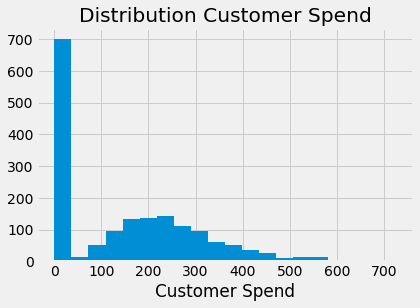

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

当数据科学家看到这一点时，他脑海中浮现的第一个想法是将建模分解为 2 个步骤。首先是参与度，即\\(Y > 0\\)的概率。在我们的支出示例中，这将建模客户是否决定支出。第二部分为那些决定参与的人建模 \\(Y\\)。它是正数条件效应。在我们的案例中，这将是客户在决定要花费任何东西后花费的金额。如果我们想估计处理 \\(T\\) 对支出的影响，它看起来像这样：
 
$
E[Y_i|T_i] = E[Y_i|Y_i>0, T_i]P(Y_i>0|T_i)
$
 
参与模型没有任何问题\\(P(Y_i>0|T_i)\\)。事实上，如果 \\(T\\) 是随机分配的，它将捕获由于处理而增加的支出概率。另外，上面的分解没有任何问题。根据总概率定律，这在数学上是正确的。
 
问题在于估算 COP 部分。 **即使在随机分配下也会有偏差**。在直观的层面上，认为某些单位只是因为没有得到处理而为零并不疯狂。处理会导致他们**不**为零。另一方面，有些单位从不为零。治疗可能会增加他们的结果，但即使没有它，他们也不会为零。现在，关键是要了解这两种类型的单位没有可比性。与那些没有接受治疗的零相比，那些从不为零的人具有较高的 \\(Y_0\\) 。事实上，对于后者，\\(Y_0=0\\)。
 
知道这一点，如果我们删除零，我们将在处理组和对照组上保留从不为零。但是我们将从控制中删除那些通过处理从零变为非零的。这将使处理和控制不再具有可比性，因为控制将只包含那些从不为零且具有更高 \\(Y_0\\) 的单元，而处理将包含两种类型的单位。
 
既然我们对问题有了直观的认识，那我们就从数学的角度来检查一下。来看一下，我们来分解一下治疗效果。在随机分配下，它等于均值差
 
$$
\begin{align*}
&E[Y_i|T_i=1] - E[Y_i|T_i=0]\\
&=E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=1) - E[Y_i|Y_i>0, T_i=0]P(Y_i>0|T_i=0)\\
&=\underbrace{\{P(Y_i>0|T_i=1) - P(Y_i>0|T_i=0)\}}_{参与 \ 效果} * E[Y_i|Y_i>0, T_i=1] \\
&+\underbrace{\{E[Y_i|Y_i>0, T_i=1] - E[Y_i|Y_i>0, T_i=0]\}}_{COP \ Effect} * P(Y_i>0|T_i= 0)
\end{align*}
$$
 
最后一个等式来自加减 \\(E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)\\) 并重新排列项。这意味着平均值的差异由两部分组成：首先，它是结果 \\(y\\) 为正的概率差异。这被称为参与效应，因为它衡量客户参与消费的可能性的增加。其次，这是以参与为条件的结果的差异，即 COP 效应。到现在为止还挺好。这没有任何问题。这是一个数学真理。当我们尝试分别估计每个部分时，问题就来了
 
如果我们进一步分析 COP 效应，这将变得更加明显。
 
$$
\begin{align*}
E[Y_i|Y_i>0, T_i=1] - E[Y_i|Y_i>0, T_i=0]&=E[Y_{i1}|Y_{i1}>0]-E[Y_{i0}|Y_ {i0}>0] \\
&=\underbrace{E[Y_{i1} - Y_{i0}|Y_{i1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{i0}|Y_{i1}>0 ] - E[Y_{i0}|Y_{i0}>0] \}}_{选择 \ 偏差}
\end{align*}
$$
 
在我们加减 \\(E[Y_{i0}|Y_{i1}>0]\\) 之后，第二个等式出现。当我们分解 COP 效应时，我们首先得到对参与者亚群的因果效应。在我们的示例中，这将是对决定花钱的人的因果影响。其次，我们得到一个偏差项，它是那些在分配到治疗时决定参与的人的 \\(Y_0\\) 差异 (\\(E[Y_{i0}|Y_{i1}>0]\\ )) 和那些即使没有治疗也参与的人 (\\(E[Y_{i0}|Y_{i0}>0]\\))。在我们的例子中，这种偏差可能是负的，因为那些在分配到治疗时花费的人，如果他们没有接受治疗，可能会比那些即使没有接受治疗的人花费更少 \\(E[Y_{i0}|Y_ {i1}>0] < E[Y_{i0}|Y_{i0}>0]\\)。

![img](./data/img/beyond-conf/cop.png)
 
现在，我知道 COP 偏差一开始是非常违反直觉的，所以我认为值得通过一个直观的例子。假设我们想估计营销活动如何增加人们在我们产品上的花费。这个营销活动是随机的，所以我们不需要担心混淆。在这个例子中，我们可以将客户分成两个部分。首先，有些人只有在看到营销活动时才会购买我们的产品。让我们称这些客户为节俭的客户。除非我们给他们额外的推动，否则他们不会花钱。还有一些客户即使没有活动也会花钱。该活动使他们花费更多，但无论如何他们已经花费了。让我们称他们为富有的客户。在图中，我用浅色和虚线显示了反事实。
 
![img](./data/img/beyond-conf/cop-ex1.png)
 
为了估计活动的 ATE，因为我们有随机化，我们需要做的就是比较处理过的和未处理过的。但是，假设我们使用 COP 公式，其中我们将估计分解为两个模型，一个估计 \\(P(Y_i>0|T_i)\\) 的参与模型和估计 \\(E[Y_i|Y_i >0]\\)。这将从分析中删除所有未花费的人。
 
![img](./data/img/beyond-conf/cop-ex2.png)
 
当我们这样做时，治疗组和对照组不再具有可比性。正如我们所看到的，未经处理的客户现在只包括即使没有活动也会消费的客户群。还要注意，我们甚至可以在这里知道偏差的方向。它将是 \\(E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]\\) 或 \\(E[Y_{i0}|\文本{节俭而富有}] - E[Y_{i0}|Rich]\\)。这显然是负面的，因为富人比节俭的顾客花费更多。因此，一旦我们只过滤了参与者群体，我们对 ATE 的估计就会有偏差，即使最初没有由于随机化而产生的偏差。我真诚地希望这能说服您像瘟疫一样避免 COP。我看到太多数据科学家在做这种单独的估算，却没有意识到它带来的问题。

为了结束选择偏差，我们需要始终提醒自己永远不要控制介于治疗和结果之间的变量，或者是结果和治疗的共同影响。 在图形语言中，以下是不良控制的样子：

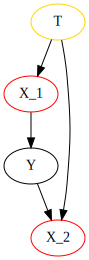

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## 关键思想

在本节中，我们查看了不是混杂因素的变量，以及我们是否应该将它们添加到我们的模型中以进行因果识别。 我们已经看到，即使不预测 \\(T\\)（不是混杂因素），也应该将作为结果 \\(y\\) 的良好预测变量的变量添加到模型中。 这是因为预测 \\(Y\\) 会降低其方差，并使我们在估计因果效应时更有可能看到具有统计意义的结果。 接下来，我们已经看到添加预测治疗而不是结果的变量是一个坏主意。 这些变量减少了治疗的可变性，使我们更难找到因果关系。 最后，我们研究了选择偏差。 当我们控制从治疗到结果的因果路径中的变量或作为治疗和结果的共同影响的变量时，就会出现偏差。